# Amazon Copurchased

This is a Python notebook created using "jupyter".

Author: Rafael J. P. dos Santos

## Condições do experimento

* Utilização de todas as features exceto métricas de rede
* Limite de 22934 ligações (~10% da base)

## Parameters

We use the parameter below to set the maximum number of edges to be read from the CSV containing edges (links).

In [1]:
max_edges = 22934 # Set quantity to read from file
edges_csv_file = "data/20180812_links"
nodes_csv_file = "data/20180812_nodes"

## Load the libraries

Let's load the Python libraries that we will need throughout the script

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import export_graphviz
import pydot
from sklearn.ensemble import RandomForestRegressor
from __future__ import division
import sklearn
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import hashlib
import sys
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.2.


## Read graph

### Read only first lines of datafile

Due to slowness in calculating centrality measures, we use the parameter provided in the beggining of the script to limit the number of edges we will read.

In [3]:
lines = []
total_line_count = 0
with open(edges_csv_file, 'rb') as f:
    f.readline()   # skip first line / header
    while True:
        line = f.readline()
        if not line:
            break
        if not (max_edges > 0 and len(lines) >= max_edges):
            lines.append(line)
        total_line_count += 1
G = nx.parse_edgelist(lines, delimiter=',', nodetype=int)

In [4]:
print "Using %d edges out of %d available (%.2f%% of data)" % (len(lines), total_line_count, len(lines)/total_line_count * 100)

Using 22934 edges out of 229338 available (10.00% of data)


### Calculate nodes centrality measures

Now that we have our NetworkX graph, let's calculate some centrality measures for every node.

In [5]:
centrality_measures = {}

#### Degree

In [6]:
centrality_measures["degree"] = nx.degree(G)

#### Eigenvector centrality

In [7]:
centrality_measures["eigenvector_centrality"] = nx.eigenvector_centrality_numpy(G)

####  Approximate betweenness centrality (current flow)

In [8]:
centrality_measures["betweenness_centrality"] = nx.approximate_current_flow_betweenness_centrality(G)

#### Closeness centrality

In [8]:
# Very slow!
centrality_measures["closeness_centrality"] = nx.closeness_centrality(G)

#### Betweenness centrality

In [9]:
# Very slow!
centrality_measures["betweenness_centrality"] = nx.betweenness_centrality(G)

### Load node properties

Let's load the CSV containing the nodes data (title, price) into a Pandas dataframe, and append the centrality measures calculated above.

In [9]:
df = pd.read_csv(nodes_csv_file)

####  Convert ID to random int to avoid leaking knowledge

In [10]:
sha256_ids = df['id'].map(lambda x: int(hashlib.sha256(str(x)).hexdigest()[0:8], 16))

In [11]:
# Add columns to dataframe
def merge_columns(dataframe, data):
    df = dataframe.copy()
    for col in data:
        rows = []
        for item in data[col].items():
            rows.append({"id": item[0], col: item[1]})
        df = df.merge(pd.DataFrame(rows))
    return df

df = merge_columns(df, centrality_measures)
df = merge_columns(df, {'sha256_id': sha256_ids})

### Let's convert some fields to numeric

In [12]:
categorical_features = [
    'category1',
    'category2',
    'category3',
    'category4',
    'category5',
    'category6',
    'category7',
    'category8',
    'category9',
    'category10',
    'language',
    'coverType',
    'publisher',
    'rankingCategory',
    'authors'
]

numeric_features = [
    #'degree',
    #'eigenvector_centrality',
    #'betweenness_centrality',
    'ranking',
    'reviewCount',
    'pages',
    'weight',
    'height',
    'width',
    'depth',
    'rating'
]

df = df.replace("<<MISSING_DATA>>", np.NaN)
df[numeric_features] = df[numeric_features].apply(pd.to_numeric)
df[['price']] = df[['price']].apply(pd.to_numeric)

for feature in numeric_features:
    df[feature].fillna(df[feature].mean(), inplace = True)

### Remove nodes without price

In [13]:
df = df.drop(df[df["price"].isnull()].index)
#df = df.drop(df[df["price"] > 500].index)

### Inspect columns

In [14]:
df.columns

Index([u'id', u'title', u'url', u'authors', u'coverType', u'publisher',
       u'edition', u'publicationDate', u'rankingCategory', u'category1',
       u'category2', u'category3', u'category4', u'category5', u'category6',
       u'category7', u'category8', u'category9', u'category10', u'isbn10',
       u'isbn13', u'language', u'postProcessed', u'price', u'ranking',
       u'pages', u'reviewCount', u'rating', u'width', u'height', u'depth',
       u'weight', u'eigenvector_centrality', u'degree',
       u'betweenness_centrality', u'sha256_id'],
      dtype='object')

### Features summary

Below we have a summary of the Pandas dataframe. We can see the number of nodes that we are actually analyzing, which depends on the max_edges parameter defined before.

In [15]:
pd.set_option('display.max_columns', None)
#df.describe(include='all')
df.describe(include='all', percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99])

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality,sha256_id
count,4907.000000,4907,4907,4907,4857,4862,0.0,444,4645,4589,4589,3384,1642,623,130,10,0.0,0.0,0.0,4864,4864,4862,4907.0,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4.907000e+03,4907.000000,4907.000000,4.907000e+03
unique,NaN,4810,4907,3468,9,476,NaN,369,1,1,28,191,338,177,49,5,NaN,NaN,NaN,4864,4864,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Macroeconomia,https://www.amazon.com.br/dp/8535931015/,Vários Autores (Autor),Capa comum,Companhia das Letras,NaN,5 de fevereiro de 2014,Livros,Livros,Literatura e Ficção,Filosofia,Matemática,Faculdade,Probabilidade e Estatística,Neurociência,NaN,NaN,NaN,8525431494,978-8521318378,Português,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5,1,51,3996,385,NaN,5,4645,4589,769,375,141,41,14,3,NaN,NaN,NaN,1,1,4163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3225.416548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,80.941406,33031.893750,369.227378,17.930282,4.434880,15.247541,22.230533,2.173314,436.701693,3.216154e-03,8.165478,0.001685,2.110908e+09
std,2171.402172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,175.628354,53225.905364,264.703081,38.474234,0.530239,2.424275,2.454402,1.264522,200.607675,1.366068e-02,21.751935,0.005969,1.230297e+09
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.900000,3.000000,4.000000,1.000000,1.000000,1.800000,8.600000,0.200000,9.100000,5.900618e-08,1.000000,0.000000,2.291770e+05
25%,1407.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,25.900000,5194.000000,208.000000,3.000000,4.300000,13.800000,20.800000,1.400000,299.000000,7.508858e-06,1.000000,0.000000,1.036745e+09
50%,3108.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,37.870000,16708.000000,312.000000,10.000000,4.437158,15.400000,22.600000,2.000000,438.082454,4.203962e-05,2.000000,0.000258,2.094500e+09
75%,4593.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,60.310000,35350.500000,448.000000,17.864682,4.800000,16.000000,23.100000,2.600000,540.000000,2.967653e-04,6.000000,0.001124,3.153880e+09


Below we can inspect the first rows of data, containing title, price, degree and other centrality measures.

In [16]:
df.head(10)

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality,sha256_id
0,1,The Stanford Mathematics Problem Book: With Hi...,https://www.amazon.com.br/dp/0486469247/,"George Polya (Autor),",Capa comum,Dover Publications,NaN,19 de fevereiro de 2009,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Estudo e Ensino,NaN,NaN,NaN,NaN,NaN,0486469247,978-0486469249,Inglês,1,26.25,59183.0,68.0,1.000000,4.000000,14.0,21.0,0.6,181.0,0.012552,19,0.002766,3564330554
1,2,Fourier Series,https://www.amazon.com.br/dp/0486633179/,"Georgi P. Tolstov (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1976,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486633179,978-0486633176,Inglês,1,50.37,56112.0,352.0,3.000000,4.600000,14.6,21.0,1.9,363.0,0.053278,62,0.002678,1309098117
2,3,Probability Theory: A Concise Course,https://www.amazon.com.br/dp/0486635449/,"Y. A. Rozanov (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486635449,978-0486635446,Inglês,1,29.23,44345.0,160.0,17.864682,4.437158,14.4,20.8,0.8,200.0,0.034380,59,0.005703,1260550007
3,4,"Vectors, Tensors and the Basic Equations of Fl...",https://www.amazon.com.br/dp/0486661105/,"Rutherford Aris (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Engenharia e Transporte,Engenharia,Mecânica,Hidráulica,NaN,NaN,NaN,NaN,0486661105,978-0486661100,Inglês,1,48.79,82275.0,320.0,2.000000,4.500000,13.7,21.5,1.6,381.0,0.011807,18,0.003271,4012708477
4,5,Ordinary Differential Equations,https://www.amazon.com.br/dp/0486649407/,"Morris Tenenbaum (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486649407,978-0486649405,Inglês,1,71.63,40840.0,848.0,4.000000,4.500000,13.8,21.8,4.0,939.0,0.074499,88,0.007335,3891707921
5,6,The Variational Principles of Mechanics,https://www.amazon.com.br/dp/0486650677/,"Cornelius Lanczos (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486650677,978-0486650678,Inglês,1,88.15,36960.0,418.0,1.000000,5.000000,13.8,21.5,2.2,581.0,0.049838,43,0.004373,2030201243
6,7,A First Look at Perturbation Theory,https://www.amazon.com.br/dp/0486675513/,James G. Simmonds (Autor),Capa comum,Dover Publications Inc.,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486675513,978-0486675510,Inglês,1,36.10,37291.0,160.0,17.864682,4.437158,13.7,21.5,0.8,159.0,0.008698,9,0.000256,744636978
7,8,Thermodynamics and the Kinetic Theory of Gases...,https://www.amazon.com.br/dp/0486414612/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,18 de outubro de 2010,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Dinâmica,Termodinâmica,NaN,NaN,NaN,NaN,0486414612,978-0486414614,Inglês,1,26.01,24406.0,160.0,2.000000,5.000000,13.8,21.6,1.0,159.0,0.004530,10,0.004486,425205287
8,9,Mechanics,https://www.amazon.com.br/dp/0486607542/,"Jacob P. Den Hartog (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1961,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486607542,978-0486607542,Inglês,1,50.96,90609.0,480.0,17.864682,4.437158,13.6,20.3,2.3,522.0,0.019468,23,0.003681,1246026773
9,10,Statistical Thermodynamics,https://www.amazon.com.br/dp/0486661016/,"Erwin Schrodinger (Autor),",Capa comum,Dover Publications,NaN,NaN,Liv

## Random forest using various features, price as target

### Preparing data

In [17]:
df_with_dummies = pd.get_dummies(df[['sha256_id'] + numeric_features + categorical_features + ['price']],columns=categorical_features,drop_first=True)

In [18]:
feature_list = list(df_with_dummies.drop(columns = ['price']))

features_values = np.array(df_with_dummies.drop(columns = ['price']))
target_value = np.array(df_with_dummies['price'])

features_and_target = np.concatenate((features_values, target_value.reshape(len(target_value), 1)), axis = 1)

#print features_and_target.shape

# Shuffle features_and_target
np.random.shuffle(features_and_target)

limit = int(round(len(target_value) * 0.8))
print "Test percentage", (len(target_value)-limit)/len(target_value)

features = features_and_target[:limit, :-1]
target = features_and_target[:limit, -1]

test_features = features_and_target[limit:, :-1]
test_target = features_and_target[limit: , -1]

print "Train features shape", features.shape
print "Train target shape", target.shape
print "Test features shape", test_features.shape
print "Test target shape", test_target.shape

Test percentage 0.199918483799
Train features shape (3926, 4746)
Train target shape (3926,)
Test features shape (981, 4746)
Test target shape (981,)


### Average price as baseline

It's important to have a baseline, so we can validate our predictions after running our model. One easy choice for baseline is the average price of a book.

We have an average price around R\$43, so this means that a very easy prediction would be to always guess R$43 for the price of any book.

In [19]:
average_target = np.average(target)
print "Average price: R$", average_target

Average price: R$ 79.88160723382578


### Cross val

#### Run cross val

In [20]:
def baseline_score_function (y_true, y_pred):
    errors_baseline = abs(average_target - y_true)
    return np.mean(errors_baseline)

def relative_error_function (y_true, y_pred):
    errors_absolute = abs(y_pred - y_true)
    errors_relative = errors_absolute / y_true
    return np.mean(errors_relative)

def baseline_relative_error_function (y_true, y_pred):
    errors_absolute = abs(average_target - y_true)
    errors_relative = errors_absolute / y_true
    return np.mean(errors_relative)

rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1)

scorer = make_scorer(baseline_score_function)
scorer2 = make_scorer(relative_error_function)
scorer3 = make_scorer(baseline_relative_error_function)

scores = cross_validate(estimator=rf, X=features, y=target, cv=10,
                        scoring = {
                            'abs': 'neg_mean_absolute_error',
                            'baseline': scorer,
                            'relative': scorer2,
                            'baseline_relative': scorer3
                        },
                        return_train_score=False, return_estimator = True)

# Use best estimator to do some visual reports
rf = scores['estimator'][0]

#### Cross val score

In [21]:
print "=== Relative"
print "RF relative abs mean: ", np.mean(np.abs(scores['test_relative']))
print "RF relative abs std: ", np.std(scores['test_relative'])

#print "Baseline: ", scores['test_baseline']
print "Baseline relative mean: ", np.mean(scores['test_baseline_relative'])
print "Baseline relative std: ", np.std(scores['test_baseline_relative'])

print "=== Absolute"

#print "Abs: ", scores['test_abs']
print "RF abs mean: ", np.mean(np.abs(scores['test_abs']))
print "RF abs std: ", np.std(scores['test_abs'])

#print "Baseline: ", scores['test_baseline']
print "Baseline mean: ", np.mean(scores['test_baseline'])
print "Baseline std: ", np.std(scores['test_baseline'])

=== Relative
RF relative abs mean:  0.34839655170276057
RF relative abs std:  0.03520023895472677
Baseline relative mean:  1.6236224913401216
Baseline relative std:  0.09314115568475
=== Absolute
RF abs mean:  27.321972000701045
RF abs std:  4.70047441235411
Baseline mean:  72.80586742985548
Baseline std:  7.959574704703783


####  List of most important features

In [22]:
importance = zip(feature_list, rf.feature_importances_)
importance.sort(key=lambda x:-x[1])
pd.DataFrame(importance).head(200)

,0,1
0,language_Inglês,0.228215
1,pages,0.171269
2,coverType_Capa dura,0.082092
3,category2_Inglês e Outras Línguas,0.070178
4,width,0.063236
5,coverType_Capa comum,0.059693
6,publisher_Cengage Learning,0.049678
7,height,0.034832
8,depth,0.026616
9,ranking,0.022703


## Test dataset and visual inspection

In [23]:
test_predictions = rf.predict(test_features)

### Predicted price vs real price

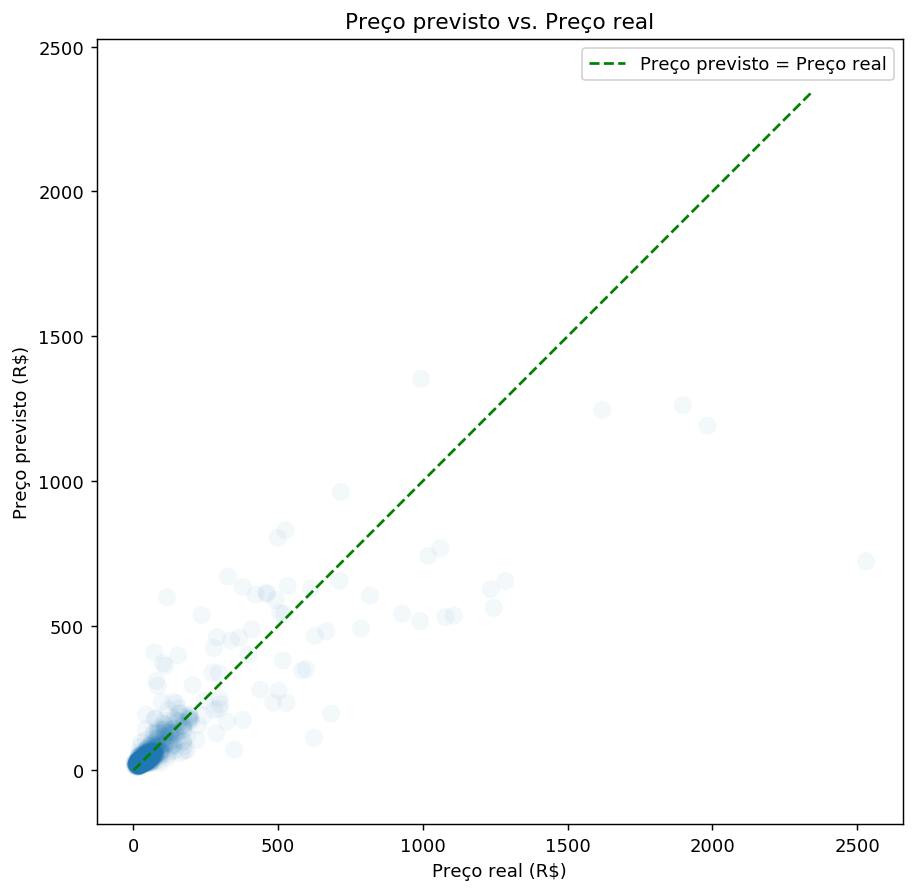

In [24]:
plt.figure(figsize=(8,8), dpi=130)
plt.scatter(test_target, test_predictions, 100, alpha=0.05, edgecolors="none")
baseline = [0, np.max(target)]
plt.plot(baseline, baseline, "--", color="green", label = u"Preço previsto = Preço real")
ax = plt.gca()
ax.set_ylabel(u"Preço previsto (R$)")
ax.set_xlabel(u"Preço real (R$)")
ax.legend()
plt.title(u"Preço previsto vs. Preço real")
plt.axes().set_aspect('equal', 'datalim')
#plt.xlim(0, 150)
#plt.ylim(0, 150)
plt.show()

### Mean absolute error

Now we can compare the errors obtained by our predictions against the errors provided by the baseline (average price). Our prediction errors should be less than the baseline errors to consider the model successful.

In [25]:
# Calculate the absolute errors
errors = abs(test_predictions - test_target)
errors_baseline = abs(average_target - test_target)
errors_relative = errors/test_target
errors_baseline_relative = errors_baseline/test_target
# Print out the mean absolute error (mae)
print "== Absolute"
print('Mean absolute prediction error: R$', round(np.mean(errors), 2))
print('Std prediction error: R$', round(np.std(errors), 2))
print('Mean absolute error using average: R$', round(np.mean(errors_baseline), 2))
print('Std prediction error using average: R$', round(np.std(errors_baseline), 2))
print "== Relative"
print('Mean relative absolute prediction error: ', round(np.mean(errors_relative), 2))
print('Std relative prediction error: ', round(np.std(errors_relative), 2))
print('Mean relative absolute error using average: ', round(np.mean(errors_baseline_relative), 2))
print('Std relative prediction error using average: ', round(np.std(errors_baseline_relative), 2))

== Absolute
('Mean absolute prediction error: R$', 30.29)
('Std prediction error: R$', 96.09)
('Mean absolute error using average: R$', 77.84)
('Std prediction error using average: R$', 173.47)
== Relative
('Mean relative absolute prediction error: ', 0.35)
('Std relative prediction error: ', 0.5)
('Mean relative absolute error using average: ', 1.62)
('Std relative prediction error using average: ', 1.71)


### Join data

In [26]:
pd.set_option('display.max_columns', None)
data = {
    "all_features": test_features.tolist(),
    "sha256_id": test_features[:, 0],
    "target": test_target,
    "prediction": test_predictions,
    "error": errors,
    "error_relative": errors_relative,
    "error_baseline": errors_baseline,
    "error_baseline_relative": errors_baseline_relative
}
predicted_df = pd.DataFrame(data = data)
joined_predicted_df = predicted_df
joined_predicted_df = predicted_df.set_index("sha256_id").join(df.set_index("sha256_id"))

### Worst absolute predictions

Below we can inspect the rows with the biggest prediction error.

In [27]:
joined_predicted_df.sort_values('error', ascending = False).head(20)

,all_features,error,error_baseline,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4.565469e+08,"[456546893.0, 33924.479509, 17.8646820027, 345...",1807.8912,2451.188393,0.968440,0.714279,723.1788,2531.07,1685,Complex Analysis Complex Analysis Complex Anal...,https://www.amazon.com.br/dp/0070006571/,"Lars V. Ahlfors (Autor),",Capa dura,McGraw-Hill Science/Engineering/Math,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0070006571,978-0070006577,Inglês,1,2531.07,33924.479509,345.000000,17.864682,4.437158,16.000000,23.100000,2.500000,438.082454,0.020976,13,0.000276
2.001051e+09,"[2001050523.0, 33924.479509, 17.8646820027, 11...",792.6076,1903.038393,0.959715,0.399717,1190.3124,1982.92,1966,Chemistry,https://www.amazon.com.br/dp/0073402680/,"Raymond Chang (Autor),",Capa dura,McGraw-Hill Science/Engineering/Math,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,007766695X,978-0077666958,Inglês,1,1982.92,33924.479509,1168.000000,17.864682,4.437158,20.300000,26.700000,4.300000,438.082454,0.001077,1,0.000000
5.445666e+08,"[544566571.0, 33924.479509, 17.8646820027, 374...",682.4322,1164.548393,0.935809,0.548389,561.9978,1244.43,2072,"The Physics Companion, 2nd Edition",https://www.amazon.com.br/dp/1138429597/,Anthony C. Fischer-Cripps (Autor),NaN,CRC Press,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1138429597,978-1138429598,Inglês,1,1244.43,33924.479509,374.054854,17.864682,4.437158,15.303145,22.281448,2.193968,438.082454,0.007464,4,0.000040
2.337783e+08,"[233778327.0, 33924.479509, 17.8646820027, 142...",636.4732,1817.688393,0.957903,0.335415,1261.0968,1897.57,2184,Biochemistry,https://www.amazon.com.br/dp/0470570954/,"Donald Voet (Autor),",Capa dura,John Wiley & Sons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0121822117,978-0470570951,Inglês,1,1897.57,33924.479509,1428.000000,17.864682,4.437158,22.400000,27.700000,5.600000,438.082454,0.002608,2,0.000199
2.187742e+09,"[2187741581.0, 287341.0, 17.8646820027, 1280.0...",630.1808,1204.738393,0.937817,0.490558,654.4392,1284.62,1952,Advanced Engineering Mathematics,https://www.amazon.com.br/dp/0470458364/,Erwin Kreyszig (Autor),Capa dura,Wiley,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,NaN,NaN,NaN,NaN,NaN,0470458364,978-0470458365,Inglês,1,1284.62,287341.000000,1280.000000,17.864682,4.437158,10.000000,25.300000,4.700000,438.082454,0.009091,4,0.000101
1.954206e+09,"[1954206171.0, 409733.0, 1.0, 402.0, 798.0, 25...",608.3178,1154.328393,0.935277,0.492880,625.8922,1234.21,1697,Introduction to Real Analysis,https://www.amazon.com.br/dp/0471433314/,"Robert G. Bartle (Autor),",Capa dura,John Wiley & Sons,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Análise Matemática,NaN,NaN,NaN,NaN,NaN,0471433314,978-0471433316,Inglês,1,1234.21,409733.000000,402.000000,1.000000,1.000000,18.200000,25.600000,2.000000,798.000000,0.020369,15,0.000220
3.374043e+09,"[3374042526.0, 33924.479509, 17.8646820027, 37...",571.4758,1026.728393,0.927814,0.516420,535.1342,1106.61,1806,Schrödinger's Killer App: Race to Build the Wo...,https://www.amazon.com.br/dp/1138429619/,Jonathan P. Dowling (Autor),NaN,CRC Press,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1138429619,978-1138429611,Inglês,1,1106.61,33924.479509,374.054854,17.864682,4.437158,15.303145,22.281448,2.193968,771.000000,0.002625,2,0.000079
1.940042e+09,"[1940041608.0, 33924.479509, 17.8646820027, 72...",547.9240,997.698393,0.925869,0.508476,529.6560,1077.58,1981,Molecular Driving Forces: Statistical Thermody...,https://www.amazon.com.br/dp/0815344309/,"Ken Dill (A

### Worst relative predictions

In [28]:
joined_predicted_df.sort_values('error_relative', ascending = False).head(20)

,all_features,error,error_baseline,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.591816e+09,"[2591815997.0, 1181.0, 2.0, 384.0, 522.0, 22.8...",24.7876,74.981607,15.302369,5.058694,29.6876,4.90,5102,Todos Envolvidos,https://www.amazon.com.br/dp/8580578108/,"Ryan Gattis (Autor),",Capa comum,Intrínseca,NaN,NaN,Livros,Livros,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8580578108,978-8580578102,Português,1,4.90,1181.000000,384.0,2.000000,3.500000,15.400000,22.800000,2.200000,522.000000,0.000006,2,0.000807
2.760304e+09,"[2760303957.0, 33924.479509, 17.8646820027, 39...",335.7760,7.851607,0.109005,4.661613,407.8060,72.03,1874,The Mathematics of Secrets – Cryptography from...,https://www.amazon.com.br/dp/0691183317/,Joshua Holden (Autor),Capa comum,Princeton University Press,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0691183317,978-0691183312,Inglês,1,72.03,33924.479509,392.0,17.864682,4.437158,15.303145,22.281448,2.193968,667.000000,0.020261,11,0.000310
2.839318e+08,"[283931800.0, 14644.0, 8.0, 192.0, 222.0, 18.4...",22.4022,74.881607,14.976321,4.480440,27.4022,5.00,4791,Um Certo Capitão Rodrigo,https://www.amazon.com.br/dp/8535905987/,Erico Verissimo (Autor),Capa comum,Companhia das Letras,NaN,NaN,Livros,Livros,Literatura e Ficção,Poesia,Europeia,NaN,NaN,NaN,NaN,NaN,NaN,8535905987,978-8535905984,Português,1,5.00,14644.000000,192.0,8.000000,4.800000,13.400000,18.400000,1.600000,222.000000,0.000074,2,0.000316
1.790101e+09,"[1790101457.0, 35903.0, 15.0, 602.0, 458.0, 17...",22.3826,74.881607,14.976321,4.476520,27.3826,5.00,3579,Baudolino,https://www.amazon.com.br/dp/8577990028/,Umberto Eco (Autor),Capa comum,Best Seller,NaN,NaN,Livros,Livros,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8577990028,978-8577990023,Português,1,5.00,35903.000000,602.0,15.000000,4.300000,11.800000,17.800000,2.200000,458.000000,0.000072,2,0.000824
1.879984e+09,"[1879983517.0, 428052.0, 17.8646820027, 400.0,...",481.6234,36.248393,0.312136,4.147278,597.7534,116.13,1853,Burn Math Class: And Reinvent Mathematics for ...,https://www.amazon.com.br/dp/0465053734/,Jason Wilkes (Autor),Capa dura,Basic Books,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Estudo e Ensino,NaN,NaN,NaN,NaN,NaN,0465053734,978-0465053735,Inglês,1,116.13,428052.000000,400.0,17.864682,4.437158,16.500000,24.100000,3.800000,590.000000,0.015481,13,0.000690
1.167407e+09,"[1167406586.0, 33924.479509, 17.8646820027, 90...",150.4428,37.371607,0.879125,3.538998,192.9528,42.51,350,Solutions of Exercises of Tensor Calculus Made...,https://www.amazon.com.br/dp/1979870705/,Taha Sochi (Autor),Capa comum,Createspace Independent Publishing Platform,NaN,19 de novembro de 2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1979870705,978-1979870702,Inglês,1,42.51,33924.479509,90.0,17.864682,4.437158,21.600000,27.900000,0.500000,290.000000,0.157707,110,0.005295
3.894233e+09,"[3894233020.0, 16006.0, 17.8646820027, 128.0, ...",20.2980,73.891607,12.335828,3.388648,26.2880,5.99,1408,Instruções Secretas dos Jesuítas,https://www.amazon.com.br/dp/8573747684/,Charles Sauvestre (Autor),Capa comum,Madras,NaN,5 de fevereiro de 2014,Livros,Livros,"Política, Filosofia e Ciências Sociais",Ciências Sociais,Folclore e Mitologia,NaN,NaN,NaN,NaN,NaN,NaN,8573747684,978-8573747683,Português,1,5.99,16006.000000,128.0,17.864682,4.437158,14.000000,21.000000,0.800000,159.000000,0.000021,1,0.000000
1.211805e+09,"[1211804555.0, 33924.479509, 17.8646820027, 31...",229.8350,0.781607,0.009881,2.905626,308.9350,79.10,2060,Quantum Physics Workbook For Dummies,https://www.amazon.com.br/dp/0470525894/,Steven Holzner (A

### Best absolute predictions

In [29]:
joined_predicted_df.sort_values('error', ascending = True).head(20)

,all_features,error,error_baseline,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.151118e+09,"[1151118347.0, 8110.0, 37.0, 368.0, 358.0, 21....",0.0184,51.991607,1.864167,0.000660,27.8716,27.89,4657,A Sereia,https://www.amazon.com.br/dp/8565765938/,Kiera Cass (Autor),Capa comum,Seguinte,NaN,NaN,Livros,Livros,Literatura e Ficção,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565765938,978-8565765930,Português,1,27.89,8110.0,368.0,37.000000,4.000000,14.0,21.0,1.4,358.000000,0.000001,1,0.000000
5.621292e+07,"[56212919.0, 54392.0, 17.8646820027, 240.0, 35...",0.0222,2.721607,0.035272,0.000288,77.1378,77.16,1856,A Most Elegant Equation: Eulers Formula and t...,https://www.amazon.com.br/dp/0465093779/,David Stipp (Autor),Capa dura,Basic Books,NaN,7 de novembro de 2017,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Matemática Pura,Álgebra,Elementar,NaN,NaN,NaN,0465093779,978-0465093779,Inglês,1,77.16,54392.0,240.0,17.864682,4.437158,15.2,22.2,2.5,358.000000,0.045226,22,0.001187
3.540574e+09,"[3540573637.0, 29566.0, 17.8646820027, 184.0, ...",0.0250,45.161607,1.300738,0.000720,34.7450,34.72,5328,Da Reviravolta dos Valores: Ensaios e Artigos,https://www.amazon.com.br/dp/8532611613/,"Max Scheler (Autor),",Capa comum,Vozes,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",Filosofia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8532611613,978-8532611611,Português,1,34.72,29566.0,184.0,17.864682,4.437158,13.6,21.0,1.0,240.000000,0.000022,1,0.000000
2.301420e+09,"[2301419506.0, 35325.0, 2.0, 320.0, 440.0, 20....",0.0352,37.801607,0.898327,0.000837,42.1152,42.08,4084,Fima,https://www.amazon.com.br/dp/8571645590/,Amós Oz (Autor),Capa comum,Companhia das Letras,NaN,NaN,Livros,Livros,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8571645590,978-8571645592,Português,1,42.08,35325.0,320.0,2.000000,5.000000,14.0,20.4,1.8,440.000000,0.000240,2,0.000133
1.190777e+09,"[1190777384.0, 9976.0, 9.0, 1030.0, 438.082454...",0.0466,112.928393,0.585698,0.000242,192.7634,192.81,862,Projeto de Máquinas,https://www.amazon.com.br/dp/8582600224/,Robert L. Norton (Autor),Capa dura,Bookman,NaN,NaN,Livros,Livros,Engenharia e Transporte,Engenharia,Mecânica,NaN,NaN,NaN,NaN,NaN,NaN,8582600224,978-8582600221,Português,1,192.81,9976.0,1030.0,9.000000,4.800000,21.2,28.4,4.0,438.082454,0.000001,2,0.000006
1.222663e+09,"[1222663487.0, 26673.0, 89.0, 228.0, 358.0, 22...",0.0642,49.561607,1.634618,0.002117,30.3842,30.32,9734,Guia Politicamente Incorreto do Sexo,https://www.amazon.com.br/dp/8544102875/,Luiz Felipe Pondé (Autor),Capa comum,LeYa,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",Filosofia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8544102875,978-8544102879,Português,1,30.32,26673.0,228.0,89.000000,3.100000,15.2,22.6,1.0,358.000000,0.000008,1,0.000000
3.235065e+09,"[3235065487.0, 9000.0, 6.0, 380.0, 640.0, 23.4...",0.0810,37.981607,0.906482,0.001933,41.8190,41.90,4502,Bem-Vindo à Casa dos Espíritos,https://www.amazon.com.br/dp/8594540086/,Christopher Buehlman (Autor),Capa dura,Darkside,NaN,NaN,Livros,Livros,"Fantasia, Horror e Ficção Científica",Fantasia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8594540086,978-8594540089,Português,1,41.90,9000.0,380.0,6.000000,2.400000,16.2,23.4,2.6,640.000000,0.000074,3,0.000549
1.399007e+09,"[1399006744.0, 28238.0, 1.0, 88.0, 181.0, 18.2...",0.1148,58.981607,2.822086,0.005493,20.7852,20.90,5335,Anjos Caídos,https://www.amazon.com.br/dp/8573029196/,Harold Bloom (Autor),Capa comum,Objetiva,NaN,NaN,Livros,Livros,Literatura e Ficção,Teoria e Crítica Literária,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8573029196,978-8573029192,Português,1,20.90,28238.0,88.0,1.000000,4.00

### Best relative predictions

In [30]:
joined_predicted_df.sort_values('error', ascending = True).head(20)

,all_features,error,error_baseline,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.151118e+09,"[1151118347.0, 8110.0, 37.0, 368.0, 358.0, 21....",0.0184,51.991607,1.864167,0.000660,27.8716,27.89,4657,A Sereia,https://www.amazon.com.br/dp/8565765938/,Kiera Cass (Autor),Capa comum,Seguinte,NaN,NaN,Livros,Livros,Literatura e Ficção,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565765938,978-8565765930,Português,1,27.89,8110.0,368.0,37.000000,4.000000,14.0,21.0,1.4,358.000000,0.000001,1,0.000000
5.621292e+07,"[56212919.0, 54392.0, 17.8646820027, 240.0, 35...",0.0222,2.721607,0.035272,0.000288,77.1378,77.16,1856,A Most Elegant Equation: Eulers Formula and t...,https://www.amazon.com.br/dp/0465093779/,David Stipp (Autor),Capa dura,Basic Books,NaN,7 de novembro de 2017,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Matemática Pura,Álgebra,Elementar,NaN,NaN,NaN,0465093779,978-0465093779,Inglês,1,77.16,54392.0,240.0,17.864682,4.437158,15.2,22.2,2.5,358.000000,0.045226,22,0.001187
3.540574e+09,"[3540573637.0, 29566.0, 17.8646820027, 184.0, ...",0.0250,45.161607,1.300738,0.000720,34.7450,34.72,5328,Da Reviravolta dos Valores: Ensaios e Artigos,https://www.amazon.com.br/dp/8532611613/,"Max Scheler (Autor),",Capa comum,Vozes,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",Filosofia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8532611613,978-8532611611,Português,1,34.72,29566.0,184.0,17.864682,4.437158,13.6,21.0,1.0,240.000000,0.000022,1,0.000000
2.301420e+09,"[2301419506.0, 35325.0, 2.0, 320.0, 440.0, 20....",0.0352,37.801607,0.898327,0.000837,42.1152,42.08,4084,Fima,https://www.amazon.com.br/dp/8571645590/,Amós Oz (Autor),Capa comum,Companhia das Letras,NaN,NaN,Livros,Livros,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8571645590,978-8571645592,Português,1,42.08,35325.0,320.0,2.000000,5.000000,14.0,20.4,1.8,440.000000,0.000240,2,0.000133
1.190777e+09,"[1190777384.0, 9976.0, 9.0, 1030.0, 438.082454...",0.0466,112.928393,0.585698,0.000242,192.7634,192.81,862,Projeto de Máquinas,https://www.amazon.com.br/dp/8582600224/,Robert L. Norton (Autor),Capa dura,Bookman,NaN,NaN,Livros,Livros,Engenharia e Transporte,Engenharia,Mecânica,NaN,NaN,NaN,NaN,NaN,NaN,8582600224,978-8582600221,Português,1,192.81,9976.0,1030.0,9.000000,4.800000,21.2,28.4,4.0,438.082454,0.000001,2,0.000006
1.222663e+09,"[1222663487.0, 26673.0, 89.0, 228.0, 358.0, 22...",0.0642,49.561607,1.634618,0.002117,30.3842,30.32,9734,Guia Politicamente Incorreto do Sexo,https://www.amazon.com.br/dp/8544102875/,Luiz Felipe Pondé (Autor),Capa comum,LeYa,NaN,NaN,Livros,Livros,"Política, Filosofia e Ciências Sociais",Filosofia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8544102875,978-8544102879,Português,1,30.32,26673.0,228.0,89.000000,3.100000,15.2,22.6,1.0,358.000000,0.000008,1,0.000000
3.235065e+09,"[3235065487.0, 9000.0, 6.0, 380.0, 640.0, 23.4...",0.0810,37.981607,0.906482,0.001933,41.8190,41.90,4502,Bem-Vindo à Casa dos Espíritos,https://www.amazon.com.br/dp/8594540086/,Christopher Buehlman (Autor),Capa dura,Darkside,NaN,NaN,Livros,Livros,"Fantasia, Horror e Ficção Científica",Fantasia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8594540086,978-8594540089,Português,1,41.90,9000.0,380.0,6.000000,2.400000,16.2,23.4,2.6,640.000000,0.000074,3,0.000549
1.399007e+09,"[1399006744.0, 28238.0, 1.0, 88.0, 181.0, 18.2...",0.1148,58.981607,2.822086,0.005493,20.7852,20.90,5335,Anjos Caídos,https://www.amazon.com.br/dp/8573029196/,Harold Bloom (Autor),Capa comum,Objetiva,NaN,NaN,Livros,Livros,Literatura e Ficção,Teoria e Crítica Literária,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8573029196,978-8573029192,Português,1,20.90,28238.0,88.0,1.000000,4.00

### Relative errors distribution

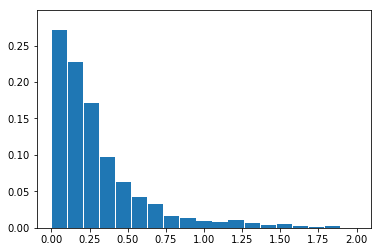

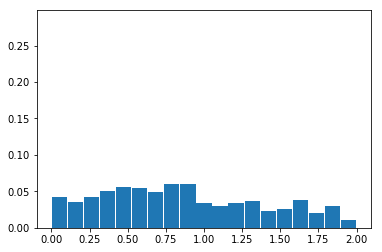

In [31]:
count = len(predicted_df.error_relative)
hist_predicted = np.histogram(predicted_df.error_relative, np.linspace(0, 2, 20))
normalized_hist_predicted = hist_predicted[0]/count
hist_baseline = np.histogram(predicted_df.error_baseline_relative, np.linspace(0, 2, 20))
normalized_hist_baseline = hist_baseline[0]/count
centers = np.convolve(hist_predicted[1], [0.5, 0.5])
centers = centers[1:-1]
plt.bar(centers, normalized_hist_predicted, width=(centers[1]-centers[0])*0.95)
ylim = max(hist_predicted[0]/count) * 1.1
plt.ylim(0, ylim)
plt.show()
plt.bar(centers, normalized_hist_baseline, width=(centers[1]-centers[0])*0.95)
plt.ylim(0, ylim)
plt.show()

#### Accumulated

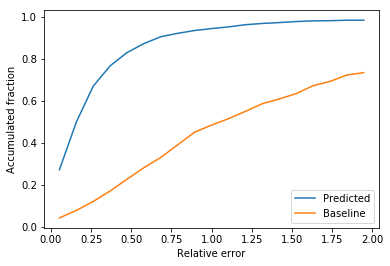

In [32]:
def accumulated_distribution(histogram):
    accumulated = []
    total = 0
    for value in histogram:
        total += value
        accumulated.append(total)
    return accumulated

    
plt.plot(centers, accumulated_distribution(normalized_hist_predicted), label='Predicted')
plt.plot(centers, accumulated_distribution(normalized_hist_baseline), label='Baseline')
plt.xlabel('Relative error')
plt.ylabel('Accumulated fraction')
plt.legend(loc='lower right')
plt.show()

### Joined data summary

In [33]:
predicted_df.describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99])

,error,error_baseline,error_baseline_relative,error_relative,prediction,sha256_id,target
count,981.000000,981.000000,981.000000,981.000000,981.000000,9.810000e+02,981.000000
mean,30.286899,77.835077,1.617930,0.347939,78.988399,2.131671e+09,85.182762
std,96.136943,173.557203,1.711105,0.497614,138.950549,1.227840e+09,190.153761
min,0.018400,0.108393,0.001355,0.000242,12.432200,9.916600e+05,4.900000
25%,3.636400,33.861607,0.566920,0.094290,28.462000,1.092166e+09,25.600000
50%,8.377800,47.951607,1.102701,0.211179,36.712400,2.148017e+09,37.990000
75%,16.512600,59.088393,2.120375,0.408127,57.242200,3.167618e+09,59.640000
85%,27.843400,65.891607,2.822086,0.564568,97.272600,3.644048e+09,97.130000
90%,47.239800,71.981607,3.440334,0.721767,148.509200,3.867861e+09,142.630000
95%,139.198800,216.018393,4.709908,1.117246,308.935000,4.041915e+09,295.900000


### Visualize decision tree

In [27]:
# Pull out one tree from the forest
tree = rf.estimators_[0]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot',
                feature_names = feature_list, rounded = True)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

<img src="files/image.png">